## Initial Code Setup

Welcome!

To begin, run each section of code by clicking the Run button above, or hitting Cntrl-Enter with the code block highlighted in order to run that block of code. Proceed through each block of code until you get to the ENTER section which will prompt you to enter housing data specific to your house.

In [133]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

# Load the CSV file into Pandas
df = pd.read_csv('data/housing_data_cleaned_transposed.csv', sep=',',skiprows=0, header=0)
df_e = pd.read_csv('data/economicData.csv', sep=',', skiprows=0, header=0)
df_physical = pd.read_csv('data/housing_size_data_cleaned.csv', sep=',', index_col=0, header=0)

df_pClean = pd.DataFrame()
df_pClean['Date'] = pd.to_datetime(df_physical['Date'], format='%Y-%m-%d')
df_pClean['Date'] = pd.to_numeric(df_pClean['Date'])
df_pClean['Prices'] = df_physical['SalePrice']
df_pClean['Quality'] = df_physical['Quality']
df_pClean['Area'] = df_physical['GrLivArea']
df_pClean['GarageCars'] = df_physical['GarageCars'] 

df_pClean.head()

,Date,Prices,Quality,Area,GarageCars
Id,,,,,
1,1496275200000000000,208500,7,1710,2
2,1496275200000000000,181500,6,1262,2
3,1496275200000000000,223500,7,1786,2
4,1496275200000000000,140000,7,1717,3
5,1496275200000000000,250000,8,2198,3


## Finding a Physical Attribute Correlations

The first thing I did was look to see if there is any correlation with any features in the dataset. I did this by creating a correlation matrix. Below is the sample code and resulting correlation maxtrix that shows a strong positive correlation with each of the following features: Quality, Ground Living Area, and Garage Size with the House Prices.


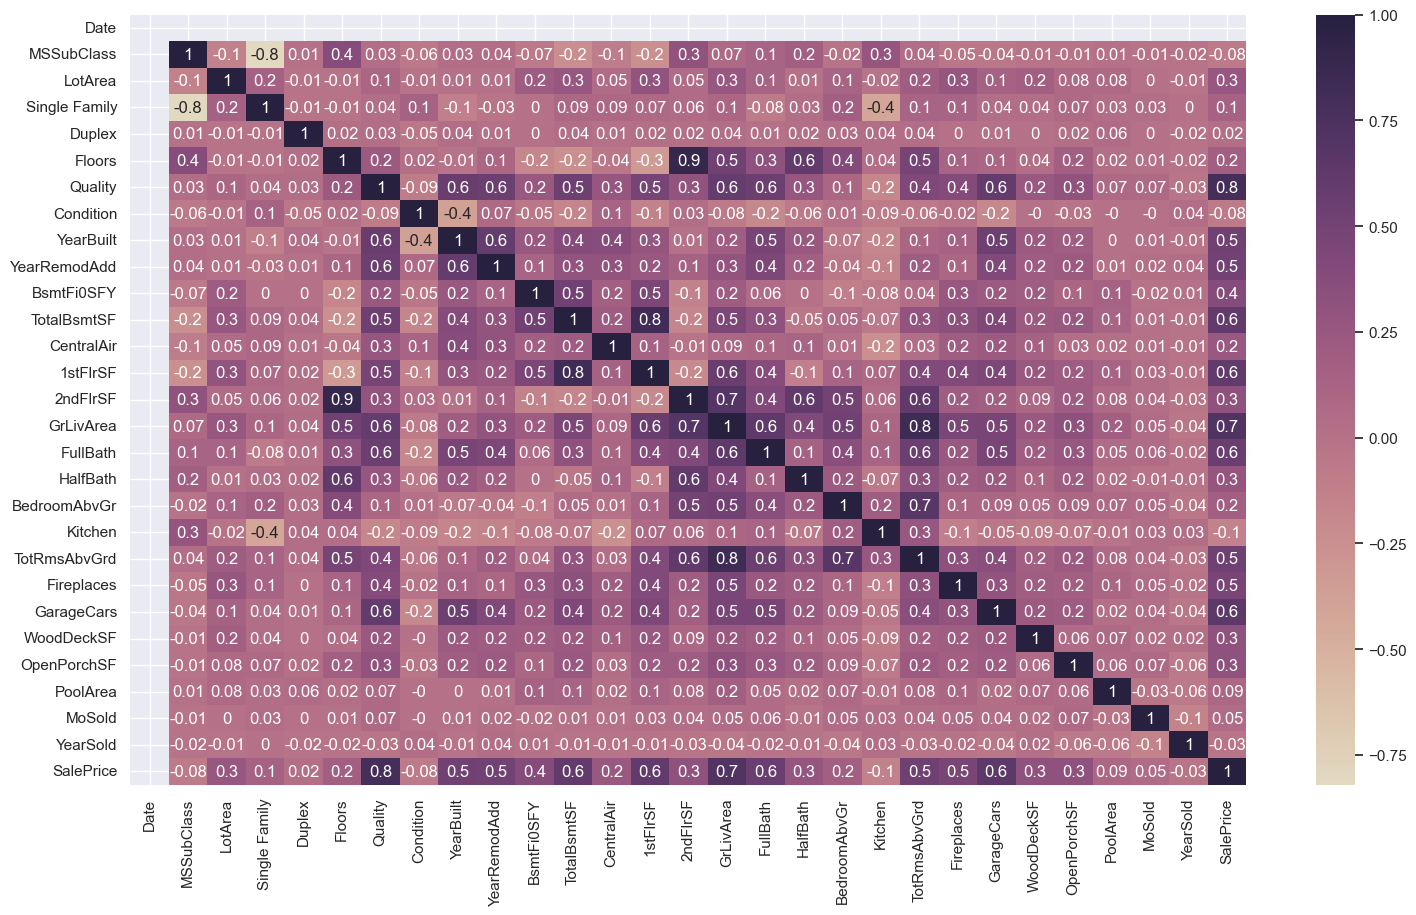

In [134]:
# Correlation Matrix for Physical Housing Data
df_physical['Date'] = pd.to_datetime(df_physical['Date'], format='%Y-%m-%d')
df_physical['Date'] = pd.to_numeric(df_physical['Date'])

sns.set(rc={'figure.figsize':(18,10)})
correlation_matrix = df_physical.corr().round(2)
colormap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
sns.heatmap(data=correlation_matrix, annot=True, fmt='.1g', cmap=colormap)

plt.show()

## Economic Data Correlations

Additionally, I wanted to determine if there was any correlation between the macroeconomic data and house prices. As can be seen in the matrix I created below, there is a strong positive correlation between Lumber prices and house prices.  I created a second feature called "ShiftedLumber" to offset the lumber data by 2 years since it appeared that lumber prices were typically a leading indicator of house prices by two years.



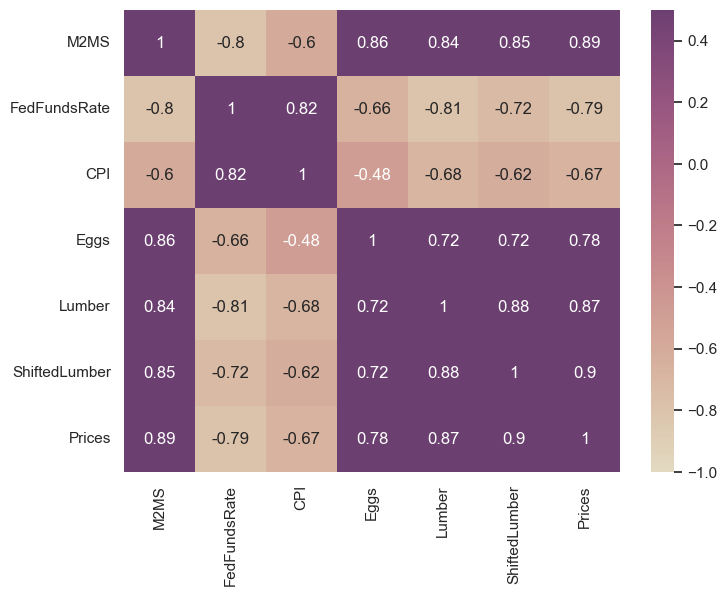

In [135]:
# Join datasets to run correlation matrix
df_e = df_e.join(df['United States'])
df_e.rename(columns={'United States': 'Prices'}, inplace=True)

# Note: 'ShiftedLumber' is shifted in time by 2 years to account for the leading indicator factor with prices
# Convert date string to datetime format to use in correlation matrix
df_e['Date'] = pd.to_datetime(df_e['Date'], format='%Y-%m-%d')
df_e['Date'] = pd.to_numeric(df_e['Date'])

vars = ['M2MS', 'FedFundsRate', 'CPI', 'Eggs', 'Lumber', 'ShiftedLumber', 'Prices']
corr = df_e.corr().round(2)        
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
sns.heatmap(corr.loc[vars,vars], annot=True, cmap=colormap, vmax=.5, vmin=-1, center=0)
plt.show()

## Housing and Macroeconomic Data with Time

To visually see the correlation of lumber and housing prices, as well as CPI (which showed a strong negative correlation), I created a plot uisng MatPlotLib to illustrate this graphically.

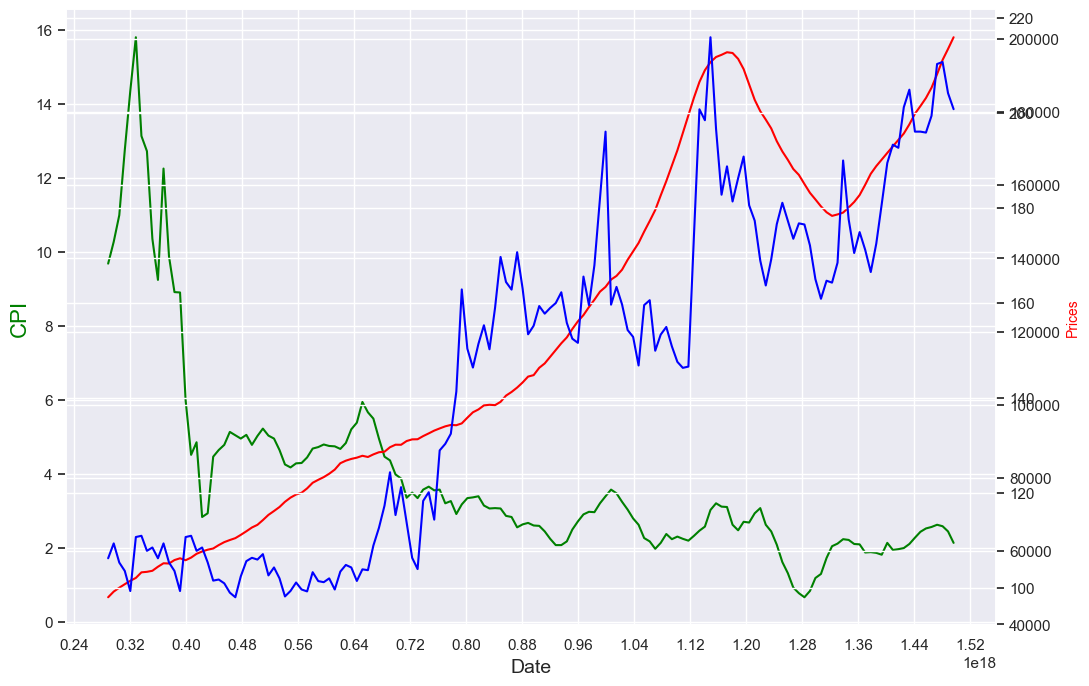

In [136]:
# Plot the rows of data as a separate line to previz to check for correlation

#define colors to use
col1 = 'green'
col2 = 'red'
col3 = 'blue'
col4 = 'black'

#define the subplots
colormap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

fig,ax = plt.subplots(figsize=(12, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(22))

# add first dataset to plot
ax.plot(df_e.Date, df_e.CPI, color=col1)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CPI', color=col1, fontsize=16)

# add second dataset to plot, along secondary y-axis
ax2 = ax.twinx()
ax2.plot(df_e.Date, df_e.Prices, color=col2)
ax2.set_ylabel('Prices', color=col2, fontsize=10)

# add third dataset (to secondary y-axis)
ax3 = ax.twinx()
ax3.plot(df_e.Date, df_e.ShiftedLumber, color=col3)
# ax3.set_ylabel('M2', color=col3, fontsize=10)


# TRAINING

## Training the Physical Feature Model

Having shown a strong correlation between several housing features and housing prices, I trained a model called "physicalModel" which is trained with the physical features of the house.

I used a Random Forest Regressor here to help better smooth out any outliers and also be able to better capture a non-linear relationship with the data. The resulting data is spit into training and test data, and subsequently plotted, along with the Mean Absolute Error to gain insight on the accuracy of the model.

Accuracy score:  0.6964755994285964
Mean Absolute Error: $ 27,898


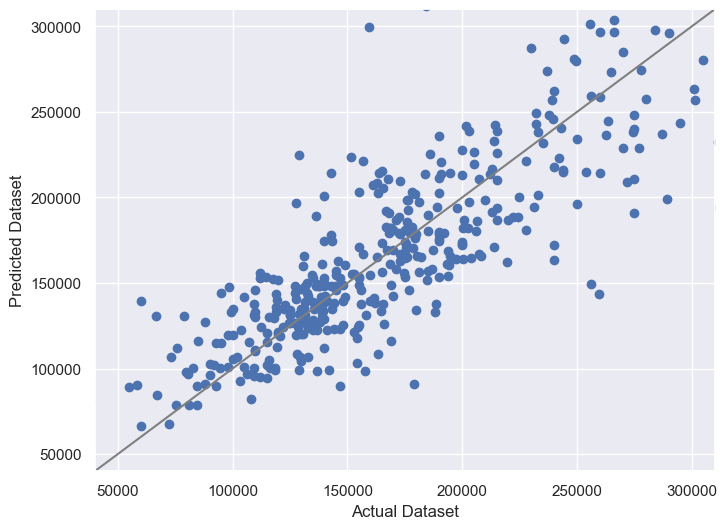

In [150]:
# Train Physical Feature Model

from IPython.display import display
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

#X1 = df_pClean[['Date', 'Quality', 'Area', 'GarageCars']]
X1 = df_pClean[['Quality', 'Area', 'GarageCars']]
y1 = df_pClean['Prices']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3)

physicalModel = RandomForestRegressor()
physicalModel.fit(X_train1, y_train1)

score = physicalModel.score(X_test1, y_test1)
print("Accuracy score: ",score)

y_pred1 = physicalModel.predict(X_test1)

metrics.mean_absolute_error(y_test1, y_pred1)
mae1 = metrics.mean_absolute_error(y_test1, y_pred1)

print('Mean Absolute Error: $ {:,}'.format(int(mae1)))

plt.scatter(y_test1, y_pred1)
plt.xlim(40000,310000)
plt.ylim(40000,310000)
plt.ylabel('Predicted Dataset')
plt.xlabel('Actual Dataset')
plt.plot([40000,310000], [40000,310000], 'grey') #1 to 1 line

## Training the Macroeconomic Feature Model

In the same way, I also created a model (I used the RandomForestRegressor for the same reason as above), named "economicModel" that is trained and tested on the macroeconomic data to pridict house prices. Again, the test data is plotted to give an idea of accuracy of the trained model. 

Accuracy score:  0.9227725328558434


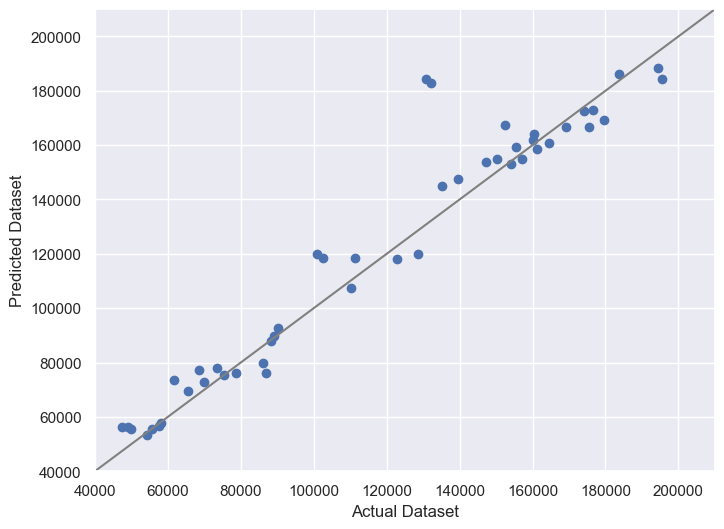

In [151]:
# Train Macroeconomic Model

from IPython.display import display
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

#X2 = df_e[['Date', 'Eggs', 'FedFundsRate', 'CPI', 'ShiftedLumber']]
X2 = df_e[['FedFundsRate', 'CPI', 'ShiftedLumber']]
y2 = df_e['Prices']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)

economicModel = RandomForestRegressor()
#economicModel = LinearRegression()
economicModel.fit(X_train2, y_train2)

score = economicModel.score(X_test2, y_test2)
print("Accuracy score: ",score)

y_pred2 = economicModel.predict(X_test2)

metrics.mean_absolute_error(y_test2, y_pred2)
mae2 = metrics.mean_absolute_error(y_test2, y_pred2)

#print('Mean Absolute Error: $ {:,}'.format(int(mae2)))
plt.scatter(y_test2, y_pred2)
plt.xlim(40000,210000)
plt.ylim(40000,210000)
plt.ylabel('Predicted Dataset')
plt.xlabel('Actual Dataset')
plt.plot([40000,210000], [40000,210000], 'grey') #1 to 1 line

## Testing the Training Sets of Each Model

I took each model and fed it realistic data to check if the predictions are in line, using actual numbers chosen manually.

## Entering House Data to Predict

This is where you can enter specific physical attributes of the house to predict the it's value. You can enter:
- The Quality (a number from 1-10)
- The Area of the house (square feet as an integer: from 500-2500)
- Garage Size (number of cars: 0, 1, 2)

After editing the values below, hit the "Run" button above or press 'Crtl-Enter'.

##
## ENTER PHYSICAL HOUSE SIZE DATA BELOW

In [139]:
quality = 8.0   # A decimal value from 1.0 - 10.0
area = 2100   # An integer from 500 - 2500
garageCars = 1   # An integer from 0-2

And then run the code below ( select the block and then click the **"Run"** icon above or press 'Crtl-Enter' )

In [140]:
# define one new data instance to test if models are within 'common sense' range

minDate =  289094400000000000
maxDate = 1496275200000000000
minPrice = 50000
maxPrice = 300000

dateRaw = '2017-03-01'
date1 = pd.to_datetime(dateRaw, format='%Y-%m-%d').timestamp()
#print(f"Date: {date1} | {dateRaw}\n")

Xphy = pd.DataFrame({'Quality': [quality], 'Area':[area], 'GarageCars': [garageCars]})
yphy = physicalModel.predict(Xphy)

Xeco = pd.DataFrame({'FedFundsRate': [1], 'CPI': [2.0], 'ShiftedLumber':[225]})
yeco = economicModel.predict(Xeco)

percentDifference = int(yphy) / int(yeco)

print('\033[1mModel Predictions\033[0m (Based on manual inputs. Physical & Economic values will be different)\n')
print('Physical Model Predicted Price: $ {:,}'.format(int(yphy)))
print(f'Economic Model Predicted Price: $ {int(yeco):,}\n')


Model Predictions (Based on manual inputs. Physical & Economic values will be different)

Physical Model Predicted Price: $ 236,406
Economic Model Predicted Price: $ 186,886



## Configure Dataframe for Forcast

I cleaned the dataframe to setup optimized for lumber (and shifted lumber for leading indcator offset).  After the dataframe is configured, I plot it to verify correlation for training.


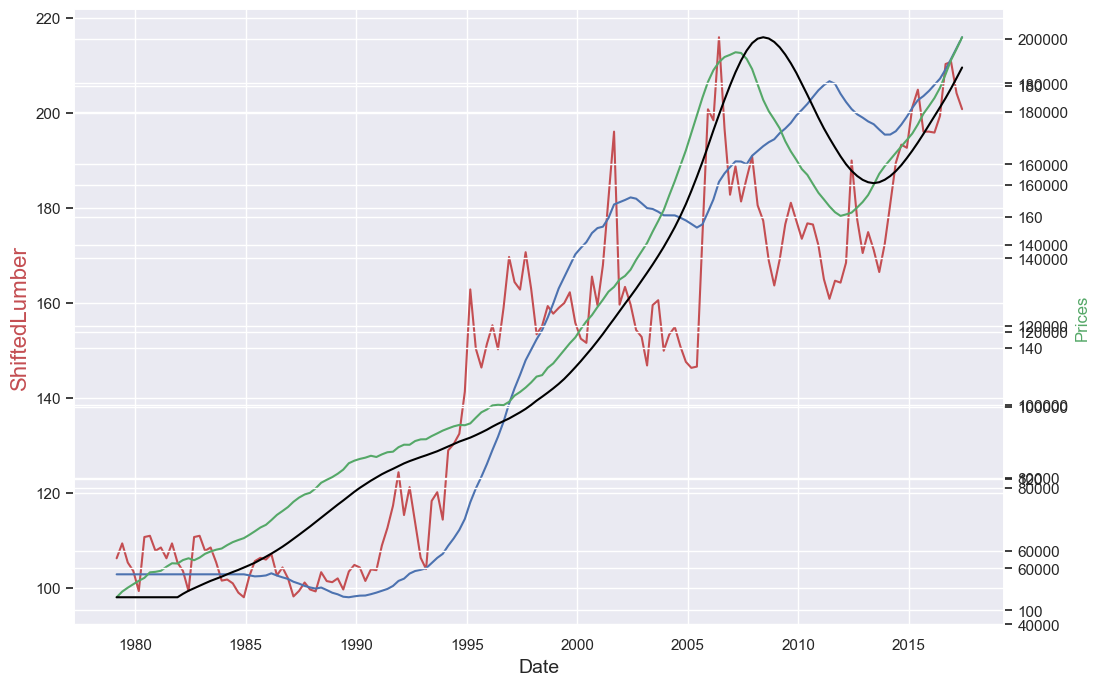

In [141]:
# Load DataFrame for Simple forcast of Lumber Price
import matplotlib.pyplot as plt

df_l = pd.DataFrame()
df_l['Date'] = df_e['Date']
df_l['Date'] = pd.to_datetime(df_l['Date'], format='%Y-%m-%d')
df_l['ShiftedLumber'] = df_e['ShiftedLumber']
df_l['LumberMA'] = df_e['ShiftedLumber'].rolling(24).mean()
df_l['PricesMA'] = df_e['Prices'].rolling(12).mean()
df_l = df_l.ffill().bfill()  # backfill NaN
df_l['Prices'] = df_e['Prices']

fig,ax = plt.subplots(figsize=(12, 8))
#ax.xaxis.set_major_locator(plt.MaxNLocator(22))

ax.plot(df_l.Date, df_l.ShiftedLumber, color='r')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ShiftedLumber', color='r', fontsize=16)

axLMA = ax.twinx()
axLMA.plot(df_l.Date, df_l.LumberMA, color='b')

axPr = ax.twinx()
axPr.plot(df_l.Date, df_l.Prices, color='g')
axPr.set_ylabel('Prices', color='g')
axPrMA = ax.twinx()
axPrMA.plot(df_l.Date, df_l.PricesMA, color='black')

##
## Train Forcast Model using Facebook's Prophet Framework

After setup it up, I train the model for forcasting using Facebook's "Prophet" framework.

Edit the following line of code for a future date. Choose any date between July, 2017 and December, 2026, to predict housing prices. Enter this date in the next code block using the format "YYYY-MM-dd" and then hit the **"Run"** command above or press 'Crtl-Enter'.

##
## ENTER DATE BELOW

In [142]:
date_to_predict = '2025-02-01'   # Enter a date between 2017-09-01 and 2026-12-31

And then run the code below ( select the block and then click the **"Run"** icon above or press 'Crtl-Enter')


On 2025-02-01:
	Lumber is forcasted to be $190

Also, on 2025-02-01:
	A house with:
	2100 square feet
	1 car garage
	general quality of 8.0
	is forcasted to be $233,048

 


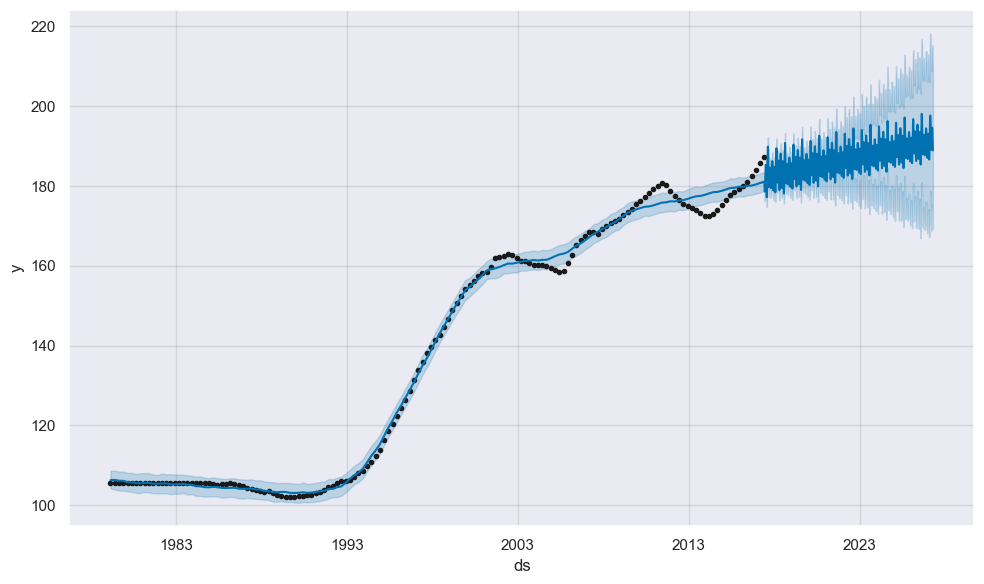

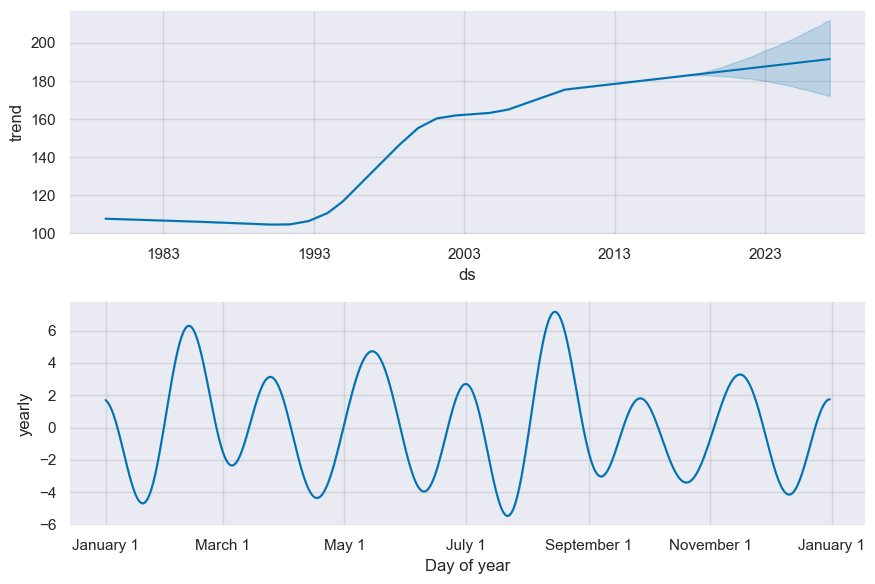

In [143]:
import pandas as pd
from prophet import Prophet
import logging
# Silences logging by facebook Prophet
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# Rename Date and LumberMA to 'ds' and 'y' for Prophet (it expects that)
data = df_l
data = data.rename(columns={'Date': 'ds', 'LumberMA': 'y'})

forcast_model = Prophet()
forcast_model.fit(data)
forecast = forcast_model.predict(future)
forcast_model.plot(forecast)
forcast_model.plot_components(forecast)


months_to_predict = 120   # Model should project up to 10 years into the future
future = forcast_model.make_future_dataframe(periods = int(months_to_predict) * 30) 
output = forecast.loc[forecast['ds'] == date_to_predict, 'yhat'].iloc[0]

specificLumber = pd.DataFrame({'FedFundsRate': [1], 'CPI': [3.0], 'ShiftedLumber':[output]})
housePriceByLumber = economicModel.predict(specificLumber)
predictedHousePrice = int(housePriceByLumber[0])
output = int(output)
predictedPhysicalHousePrice = int(percentDifference * predictedHousePrice)

print(f'\033[1m\nOn {date_to_predict}:\n\tLumber is forcasted to be ${output:,d}\n\nAlso, on {date_to_predict}:\n\tA house with:\n\t{area} square feet\n\t{garageCars} car garage\n\tgeneral quality of {quality}\n\tis forcasted to be ${predictedPhysicalHousePrice:,d}\n\n \033[0m')
                             